# JuliaCon 2020

### Complex graphs in transportation networks with OpenStreetMapX.jl 

#### Przemysław Szufel & Bogumił Kamiński

Any transportation network can be represented as a complex directed graph where vertices are spread an Euclidean space. The library provides a bridging functionality between real world spatial data available in the OpenStreetMap project and LightGraphs.jl and makes it possible to run real-life-sized experiment on transportation networks along with various visualizations.

A transportation system or even an entire city can be represented as a complex directed graph embedded in an Euclidean space. Such graph can model real world in 1:1 scale and be used to perform various numerical experiments. The [*OpenStreetMapX.jl*](https://github.com/pszufe/OpenStreetMapX.jl/) package makes it possible to load the data from the OpenStreetMap.org project and processes such graphs with Julia. The package is using LightGraphs.jl to represent the directed graph structure object along with meta related to spatial information. For the graph vizualisation we will use Python's *folium* package for providing an interactive vizualization of results.

This notebook can be downloaded in Jupyter ipynb format [here](https://pszufe.github.io/OpenStreetMapX_Tutorial/JuliaCon2020/Pandemic_Broadcasting_Sim.ipynb) (right-click to download).
The source code uses a `torontoF.osm` file which you can also download [here](https://pszufe.github.io/OpenStreetMapX_Tutorial/JuliaCon2020/torontoF.osm).

Firstly, let us start by installing the required Julia and Python packages.

In [ ]:
using Pkg
pkg"add OpenStreetMapX, Parameters, LightGraphs, PyCall, Conda, Colors"
using Conda
Conda.runconda(`install folium -c conda-forge`)

Now we are ready to load all required packages

In [1]:
using Random
using Parameters
using OpenStreetMapX
using LightGraphs
using PyCall
using Colors
const flm = pyimport("folium");

In [3]:
pwd()  # use to check in which foler you are, the folder should contain the torontoF.osm file

We start by loading the file. Note that we trim the map file to have a fully connected road network.

> The file was downloaded from the [OpenStreetMap](https://www.openstreetmap.org/) project web page. The steps included: (1) Select some area on map; (2) Click the "Export" button at the top of the page; (3) Click "Manually select a different area" to select the central Toronto area; (4) Press the "Export" button on the left (note that sometimes the Export link does not work - in this case click one of the Overpass API link below the Export button).



In [79]:
m = get_map_data("torontoF.osm", use_cache=false, trim_to_connected_graph=true );

In [80]:
fieldnames(MapData)

(:bounds, :nodes, :roadways, :intersections, :g, :v, :n, :e, :w, :class)

The central element of the `MapData` object is a `LightGraphs`' representation of the road network

In [81]:
m.g

{384, 851} directed simple Int64 graph

The LightGraph graph is represented by nodes, each node id can be directly mapped to OpenStreetMap. 

In [82]:
m.n

Dict{Int64,Int64} with 384 entries:
  288 => 966480930
  306 => 29688407
  11  => 286266838
  134 => 24959559
  215 => 29604692
  158 => 34600564
  160 => 29689435
  29  => 4580791471
  131 => 3888129378883657099
  249 => 835057395
  207 => 29604717
  300 => 1553140355
  384 => -3253259596853337043
  173 => 966509309
  289 => 246692483
  201 => 2689255328
  74  => 3081114197
  176 => 29604689
  57  => 29604864
  31  => 34935422
  285 => 242413453
  70  => 123347984
  318 => 29605005
  335 => 4546585928
  33  => 42606901
  ⋮   => ⋮

Furhther those nodes can be presented as geographic coordinates

In [83]:
m.nodes

Dict{Int64,ENU} with 1137 entries:
  394502528  => ENU(-523.482, -352.173, -0.0311894)
  835054871  => ENU(-801.745, -82.3701, -0.0508429)
  6532307619 => ENU(248.966, 233.515, -0.00913427)
  773004737  => ENU(-875.589, 148.828, -0.0617441)
  4580791469 => ENU(267.533, -145.443, -0.00726341)
  6532307626 => ENU(238.71, 105.877, -0.00534034)
  6378669383 => ENU(-442.049, 87.1547, -0.0158907)
  773495344  => ENU(-465.319, 2.7827, -0.0169473)
  2143484760 => ENU(-734.89, 48.4824, -0.0424541)
  773495404  => ENU(-284.82, 43.8483, -0.00650028)
  29604854   => ENU(-140.475, -192.1, -0.00444293)
  3099846296 => ENU(127.767, 397.648, -0.0136973)
  528518666  => ENU(143.488, -17.9198, -0.00163666)
  6532307456 => ENU(-10.0918, -346.06, -0.0094142)
  2002085850 => ENU(819.731, -327.956, -0.0610404)
  24959510   => ENU(141.64, 401.848, -0.0142536)
  773004746  => ENU(-871.056, 146.983, -0.0610815)
  7590238173 => ENU(17.2615, 373.026, -0.0109526)
  6400935164 => ENU(487.805, 380.854, -0.0300169)


Let's take 10 cars an let them drive between randomly selected pairs of points

In [84]:
Random.seed!(0)
node_ids = collect(keys(m.nodes)) 
routes = Vector{Vector{Int}}()
for k in 1:10
    a,b = rand(1:nv(m.g), 2)
    route, route_time = OpenStreetMapX.shortest_route(m,m.n[a],m.n[b])
    push!(routes, route)
end                                   

Now we will plot those routes 

In [85]:
fm = flm.Map()
colrs = distinguishable_colors(10, [RGB(1,0.6,0.5)])
for k=1:10
    locs = [LLA(m.nodes[n],m.bounds) for n in routes[k]]
    info = "The route of Car $k\n<BR>"*
        "Length: $(length(routes[k])) nodes\n<br>" *
        "From: $(routes[k][1]) $(round.((locs[1].lat, locs[1].lon),digits=4))\n<br>" *
        "To: $(routes[k][end]) $(round.((locs[end].lat, locs[end].lon),digits=4))"
    flm.PolyLine(        
        [(loc.lat, loc.lon) for loc in locs ],
        popup=info,
        tooltip=info,
        color="#$(hex(colrs[k]))"
    ).add_to(fm)
end

MAP_BOUNDS = [(m.bounds.min_y,m.bounds.min_x),(m.bounds.max_y,m.bounds.max_x)]
flm.Rectangle(MAP_BOUNDS, color="black",weight=6).add_to(fm)
fm.fit_bounds(MAP_BOUNDS)
fm

PyObject <folium.folium.Map object at 0x000000004BE16908>

Let now us try to built a simple simulation model of a pandemic in the city.

We start with a definition of an `Agent`

In [86]:
@with_kw mutable struct Agent
    id::Int
    last_node::Int=-1
    current_node::Int
    infected::Bool = false
    infection_time::Int = -1
    total_route_len::Int = 0
end

Agent

Once the agent is defined let us define the enviroment where they can move around.

In [87]:
@with_kw struct Simulation
    agents::Vector{Agent} 
    m::OpenStreetMapX.MapData
    nodes_infected::Vector{Set{Int}}
    nodes_agents::Vector{Set{Int}}
    infected_agents_count::Vector{Int}
end

function Simulation(m::OpenStreetMapX.MapData, N=100)
    vv = size(m.g)[1] # number of vertices
    nodes_infected = [ Set{Int}() for s in 1:vv ]
    nodes_agents =   [ Set{Int}() for s in 1:vv ]
    agents = Agent[]
    for i in 1:N
        a = Agent(id=i, current_node=rand(1:vv))
        push!(agents, a)
        push!(nodes_agents[a.current_node], a.id)
    end
    agents[1].infected = 1 # we start with one sick agent
    agents[1].infection_time = 0    
    push!(nodes_infected[agents[1].current_node], 1)   
    
    Simulation(agents=agents, m=m, nodes_infected=nodes_infected,
        nodes_agents=nodes_agents, infected_agents_count=[1])
end

Simulation

In [88]:
s = Simulation(m)

Simulation
  agents: Array{Agent}((100,))
  m: MapData
  nodes_infected: Array{Set{Int64}}((384,))
  nodes_agents: Array{Set{Int64}}((384,))
  infected_agents_count: Array{Int64}((1,)) [1]


Now we define the plotting function which is indeed similar to the previous one

In [89]:
function latlon(s::Simulation,map_g_point_id::Int64)
    osm_node_ix = s.m.n[map_g_point_id]
    lla = LLA(s.m.nodes[osm_node_ix], s.m.bounds)
    return (lla.lat, lla.lon)
end

function plot_sim(s::Simulation; tiles="Stamen Toner" )
    MAP_BOUNDS = [( s.m.bounds.min_y, s.m.bounds.min_x),( s.m.bounds.max_y, s.m.bounds.max_x)]
    map_size = (abs(MAP_BOUNDS[1][1]-MAP_BOUNDS[2][1]), abs(MAP_BOUNDS[1][2]-MAP_BOUNDS[2][2]))
    MAP_BOUNDSx9 = [ (MAP_BOUNDS[1][1]-map_size[1], MAP_BOUNDS[1][2]-map_size[1]),
                     (MAP_BOUNDS[2][1]+map_size[1], MAP_BOUNDS[2][2]+map_size[1])]
    m_plot = flm.Map(tiles=tiles)

    for e in edges(s.m.g)
        flm.PolyLine(     (latlon(s,e.src), latlon(s,e.dst)),
            color="red", weight=5, 
            opacity=1).add_to(m_plot)
    end

    for v in 1:nv(s.m.g)
        info =  "<b>Node</B>\n<br> OSM id: $(s.m.n[v])\n <br>Node: $(v) "
        flm.Circle(
            latlon(s,v),
            popup=info,
            tooltip=info,
            radius=10,
            color="blue",
            weight=3,
            fill=true,
            fill_color="blue"
          ).add_to(m_plot)
    end

    jitter =  2.5e-4

    for agent in s.agents
        info = "Agent: $(agent.id)\n<br>Infected: " *
            (agent.infected ? "<b>YES</b>" : "NO")*
            "\n<br>Current node: $(agent.current_node)"*
            "\n<br>Previous node: $(agent.last_node)"*
            "\n<br>Total distance travelled so far $(agent.total_route_len)"
        loc =  latlon(s,agent.current_node) .+ jitter.*randn(2)
        sizex = agent.infected ? 0.0002 : 0.00016
        sizey = agent.infected ? 0.0002 : 0.00022
        flm.Rectangle(
            [(loc[1]-sizex, loc[2]-sizey), (loc[1]+sizex, loc[2]+sizey)],
            popup=info,
            tooltip=info,
            color=(agent.infected ? "green" : "black"),
            weight=(agent.infected ? 5 : 1.5),
            fill=(agent.infected ? false : true),
            fill_opacity=(agent.infected ? 0.2 : 1.0),
            fill_color=(agent.infected ? "green" : "#FAFAFA"),
        ).add_to(m_plot)
    end
    MAP_BOUNDS = [( s.m.bounds.min_y, s.m.bounds.min_x),( s.m.bounds.max_y, s.m.bounds.max_x)]
    flm.Rectangle(MAP_BOUNDS, color="brown",weight=4).add_to(m_plot)
    m_plot.fit_bounds(MAP_BOUNDS)
    #m_plot.save("mysim.html")  # uncomment to save to a file
    m_plot
end

plot_sim (generic function with 1 method)

In [90]:
plot_sim(s)

PyObject <folium.folium.Map object at 0x000000005B04D188>

Now we need to define how the agents move around

In [91]:
function step!(s::Simulation)
    agent = rand(s.agents)
    pop!(s.nodes_agents[agent.current_node], agent.id )
    agent.total_route_len += 1
    agent.infected && pop!(s.nodes_infected[agent.current_node], agent.id)

    ns = LightGraphs.neighbors(s.m.g, agent.current_node)
    
    new_node = rand(ns)
    
    agent.last_node = agent.current_node
    agent.current_node = new_node
    new_infections = 0
    if agent.infected
        for id in s.nodes_agents[new_node]
            if ! s.agents[id].infected
                s.agents[id].infected = true
                s.agents[id].infection_time = length(s.infected_agents_count)
                push!(s.nodes_infected[new_node], id)
                new_infections += 1
            end  
        end
    else
        if length(s.nodes_infected[new_node]) > 0
            agent.infected = true
            agent.infection_time = length(s.infected_agents_count)
            new_infections += 1
        end
    end
    if agent.infected
        push!(s.nodes_infected[new_node], agent.id)
    end
    push!(s.nodes_agents[new_node], agent.id)
    push!(s.infected_agents_count,s.infected_agents_count[end]+new_infections)
    
end

step! (generic function with 1 method)

We run the simulation for 10000 steps and watch the pandemic to develop

In [94]:
Random.seed!(1)
s = Simulation(m)
for i in 1:5000
    step!(s)
end
plot_sim(s)

PyObject <folium.folium.Map object at 0x000000006D2A1648>

In [99]:
using Plots
Random.seed!(1)
function randres(N=200,steps=10000)
    s = Simulation(m,N)
    for i in 1:steps
        step!(s)
    end
    s.infected_agents_count ./ N
end
res_total = hcat((randres(200,15000) for i in 1:200)...);

In [100]:
using Statistics

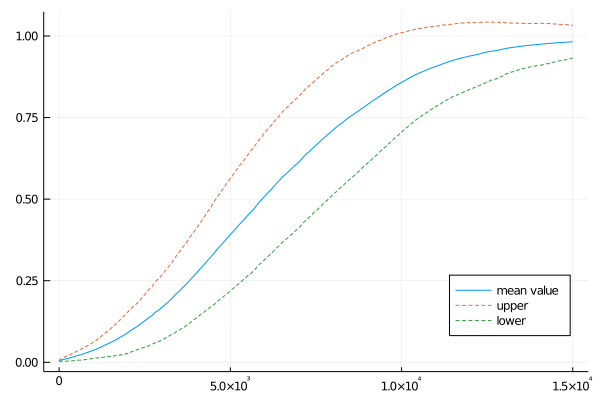

In [101]:
mvs = mean(res_total,dims=2)
plot(mvs, legend=:bottomright, lab="mean value")
plot!(mvs.+std(res_total,dims=2), linestyle=:dash, lab="upper")
plot!(mvs.-std(res_total,dims=2), linestyle=:dash, lab="lower")


In [107]:
res100 = hcat((randres(100,25000) for i in 1:200)...);
res200 = hcat((randres(200,25000) for i in 1:200)...);
res500 = hcat((randres(500,25000) for i in 1:200)...);

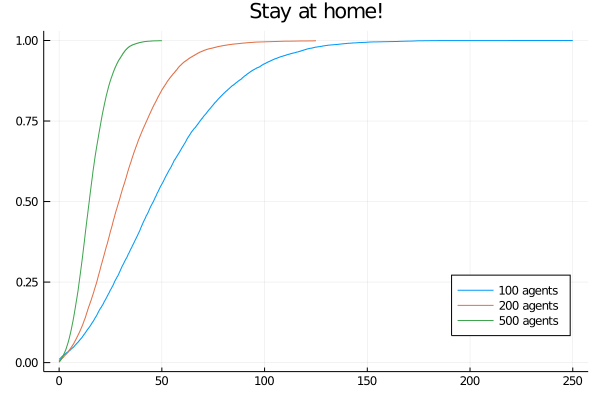

In [108]:
plot(collect(1:25001) ./100 , mean(res100,dims=2), legend=:bottomright, lab="100 agents")
plot!(collect(1:25001) ./200, mean(res200,dims=2), lab="200 agents")
plot!(collect(1:25001) ./500, mean(res500,dims=2), lab="500 agents")
title!("Stay at home!")